# 뉴스 기사 요약해보기



평가문항과 상세기준
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

## 1. 데이터 수집

아래의 링크의 '뉴스 데이터'를 사용했다.  
[링크]https://github.com/sunnysai12345/News_Summary 

In [1]:
# 다운로드
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 다운된 데이터 샘플 일부(10개) 확인

data.sample(10)

,headlines,text
61608,Imtiaz changed my life: Nargis on Rockstar com...,On the completion of six years of her Bollywoo...
11457,Is life worth one pic? Woman who fell 800ft in...,"India's 30-year-old Meenakshi Moorthy, who die..."
73040,Madhya Pradesh Vyapam scam whistleblower's fat...,Vyapam scam whistleblower Ashish Chaturvedi's ...
16803,Will pay Ã¢ÂÂ¹20L to BJP leader who agrees to...,Haryana Aam Aadmi Party chief Naveen Jaihind o...
82748,"Kareena, Abhishek's debut film Refugee complet...",Kareena Kapoor and Abhishek Bachchan's debut f...
39502,Which startups has $100-bn SoftBank Vision Fun...,Masayoshi Son-led SoftBank's $100-billion Visi...
43824,Mauritius President refuses to resign over fin...,Vowing to fight allegations levelled against h...
95482,Punjab police arrests prime accused in Nabha j...,The Punjab police has arrested one of the prim...
6020,"Indian-origin woman faked cancer, tricked fami...",Indian-origin woman Jasmin Mistry was sentence...
35374,Govt removes 44 districts from Naxal-affected ...,The government has removed 44 districts where ...


## 2. 데이터 전처리하기
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

In [2]:
# 중복 샘플과 NULL 값 체크 

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headline 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headline 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [3]:
# 중복 샘플 제거하기
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수: ', (len(data)))

전체 샘플수:  98360


#### text의 중복이 없다.

In [4]:
# NULL 샘플 총합
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


check result: headline과 text 열에 null값 없다. dropna 작업은 Pass

In [5]:
# text normalization을 통해 불용어 제거할 것임.

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [6]:
# Check stopwords count(NLTK 사용, 영어)

#NLTK패키지에서 stopwords 사전과 데이터 전처리를 위한 부분 다운로드
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print('stopwords 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

stopwords 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# 문장 전처리 메소드 정의
from bs4 import BeautifulSoup 
import re

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
# 임시 데이터를 만들어 이를 preprocess_sentence()에 넣어봄

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


Result: 모든 텍스트를 소문자로 바꿨고, 불필요한 태그나, 특수문자 등을 제거함.

In [9]:
# Multi processing을 사용하여 전처리를 할 것이다.
# Text의 경우에는 stopwords 제거, Summary의 경우에는 제거하지 않을 것이다.
# 이 둘을 따로 처리함.

# 메소드 정의 
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data


In [10]:
# 위 두 메소드를 통해 전처리&확인

clean_text = preprocess_data(data['text']) 
print(clean_text)
print('-------------')
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) #불용어 제거 수행 안함.
print(clean_headlines)

347.81167936325073  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

#### Result: text 부분에서는 stopwords를 제거했고, headlines 부분에서는 살려뒀다.


In [11]:
# 데이터 확인 후 빈 값을 null로 처리

data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('',np.nan, inplace = True)

In [12]:
# 다시 Null 체크

data.isnull().sum()

headlines    0
text         0
dtype: int64

null이 없어가지고 그대로임.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
Headline의 최소 길이 : 1
Headline의 최대 길이 : 16
Headline의 평균 길이 : 9.299532330215534


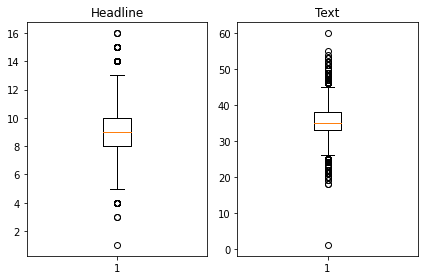

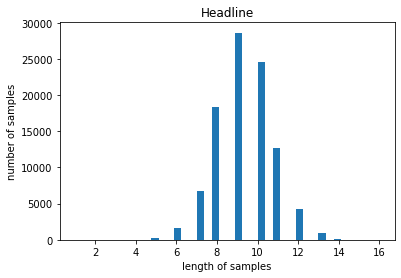

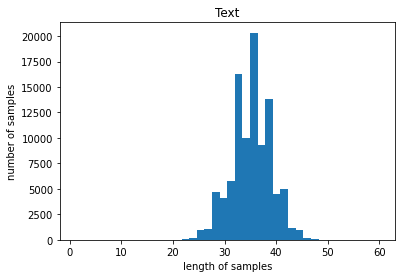

In [13]:
### 이제 학습 데이터의 크기를 정한다.

# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('Headline의 최소 길이 : {}'.format(np.min(headline_len)))
print('Headline의 최대 길이 : {}'.format(np.max(headline_len)))
print('Headline의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Result: text의 평균길이가 35인데 요약을 통해 길이 9까지 줄였다.  상당히 축약됐다.

In [14]:
# 한번 더 전처리 작업( text와 headline의 적절한 최대 길이를 세팅)
# 사실 이 데이터는 텍스트의 길이가 길지 않지만 그래도 좀 줄여 보겠음
# text: 60 -> 50, headline: 16 ->8

text_max_len = 50
headline_max_len = 8


In [15]:
# 설정한 최대 길이가 기존 샘플의 몇%을 커버하는지 확인하는 메소드 정의

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
# 확인해보자

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


비율의 밸런스가 좋지 않다. 좀 더 수정해보겠다.

In [17]:
text_max_len = 38
headline_max_len = 11

In [18]:
# 다시 확인해보자

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.8163379422529483
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


In [19]:
# 정해진 길이 보다 긴 것은 제외한다.

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 75754


#### Result: 전체 샘플 수가 98360에서 75754개로 줄어듬

In [20]:
# 헤드라인 데이터에 필요한 시작 token과 종료 token을 추가하겠다.

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...
8,called pm modi sir times to satisfy his ego an...,andhra pradesh cm chandrababu naidu said met u...,sostoken called pm modi sir times to satisfy h...,called pm modi sir times to satisfy his ego an...


#### Result:  앞뒤로 'sostoken'이 붙었음을 확인했다.

In [21]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy타입으로 저장한다.

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터를 분리하기

In [22]:
# encoder_input 크기와 형태가 같은 순서가 섞인 정수 시퀀스로 만들기

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[68518 13079 67854 ... 50990 39743 55991]


In [23]:
# 샘플 순서 다시 정의해주기

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 데이터를 8:2로 훈련 데이터와 테스트 데이터로 나눈다.

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15150


In [25]:
# 데이터를 나눈다.

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 60604
훈련 레이블의 개수 : 60604
테스트 데이터의 개수 : 15150
테스트 레이블의 개수 : 15150


In [26]:
# 정수 인코딩
# 기계가 숫자로 처리할 수 있도록 train data, test data를 정수로 바꿔야 한다.
# Keras의 토크나이저를 사용하면 단어 집합을 만들 수 있다.

from tensorflow.keras.preprocessing.text import Tokenizer 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 집합이 생성되는 동시에 각 단어에 대한 고유한 정수가 부여되었고,  
생성된 단어 집합은 src_tokenizer.word_index에 저장된다.

In [27]:
# 모든 단어를 쓰지 않고, 빈도수가 낮은 단어는 제외할 것이다. (빈도가 7회미만)

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 60336
등장 빈도가 6번 이하인 희귀 단어의 수: 41234
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19102
단어 집합에서 희귀 단어의 비율: 68.34062582869265
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.075651158691967


In [28]:
# 훈련 데이터에서 단어 집합의 크기를 8천개로 맞추기 (왜 8000개인가? )

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환시키기

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[656, 491, 1309, 40, 3850, 858, 416, 476, 32, 351, 3217, 2087, 1, 722, 227, 942, 476, 102, 1278, 724, 2, 61, 31, 8, 69, 805, 488, 858, 1151, 103, 6203, 68, 4254], [395, 186, 853, 77, 57, 255, 853, 107, 1661, 2748, 544, 1, 892, 853, 4462, 5, 19, 133, 52, 10, 755, 1661, 1600, 529, 10, 27, 255, 853, 107, 591, 1601, 33, 514, 1187, 1890], [163, 17, 65, 66, 632, 1226, 1766, 2144, 1487, 593, 2694, 3851, 953, 349, 22, 1947, 2670, 349, 23, 1947, 319, 17, 452]]


In [30]:
# headlines 데이터도 마찬가지로  text2seq 처리하기

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여 되었음.
이는 tar_tokenizer.word_index에 저장된다.

In [31]:
# 역시 빈도수 6미만은 걸러내기

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27065
등장 빈도가 5번 이하인 희귀 단어의 수: 18020
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9045
단어 집합에서 희귀 단어의 비율: 66.58045446148162
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.625483726424702


In [32]:
#희귀 단어의 비율만큼 비중이 적은 단어들( 2000개 정도) 제거 할 것이다.

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 459, 1785, 6, 1240, 1011], [1, 358, 3, 4, 33, 46, 637, 1072, 482, 170], [1, 204, 83, 789, 896, 22, 6, 142, 62], [1, 1482, 1966, 5, 43, 66, 10, 206, 1101, 778], [1, 6, 44, 1181, 4, 46, 1302, 163]]
target
decoder  [[459, 1785, 6, 1240, 1011, 2], [358, 3, 4, 33, 46, 637, 1072, 482, 170, 2], [204, 83, 789, 896, 22, 6, 142, 62, 2], [1482, 1966, 5, 43, 66, 10, 206, 1101, 778, 2], [6, 44, 1181, 4, 46, 1302, 163, 2]]


#### Result: 이렇게 정수 인코딩 작업이 끝나게 된다.  현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않는다. 

In [33]:
#훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를  
#각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 8
삭제할 테스트 데이터의 개수 : 1


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 60596
훈련 레이블의 개수 : 60596
테스트 데이터의 개수 : 15149
테스트 레이블의 개수 : 15149


#### Result: 약간의 데이터 삭제가 이루어짐.

In [34]:
# 패딩하기 
# 텍스트 시퀀스 -> 정수 시퀀스에서 서로 다른 길이의 샘플들을 병렬 처리
# 하기 위해 같은 길이로 맞춰주는 패딩 작업을 한다.
# pad sequence를 위해 import 
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

### 이렇게 학습에 필요한 데이터 전처리가 끝남.

## 3. Model

In [35]:
# 함수형 API를 사용하여 encoder를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [36]:
#디코더 설계하기

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 매커니즘 적용

In [38]:
# 공개된 어텐션 함수 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

### Decoder 출력층 수정

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### Training 
#### with (EarlyStopping, rmsprop)

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
237/237 [==============================] - 738s 3s/step - loss: 4.5674 - val_loss: 3.9277
Epoch 2/50
237/237 [==============================] - 711s 3s/step - loss: 3.8390 - val_loss: 3.6051
Epoch 3/50
237/237 [==============================] - 714s 3s/step - loss: 3.5402 - val_loss: 3.4002
Epoch 4/50
237/237 [==============================] - 711s 3s/step - loss: 3.3255 - val_loss: 3.2413
Epoch 5/50
237/237 [==============================] - 711s 3s/step - loss: 3.1499 - val_loss: 3.1252
Epoch 6/50
237/237 [==============================] - 707s 3s/step - loss: 3.0188 - val_loss: 3.0435
Epoch 7/50
237/237 [==============================] - 439s 2s/step - loss: 2.9211 - val_loss: 2.9786
Epoch 8/50
237/237 [==============================] - 706s 3s/step - loss: 2.8232 - val_loss: 2.9225
Epoch 9/50
237/237 [==============================] - 707s 3s/step - loss: 2.7356 - val_loss: 2.8826
Epoch 10/50
237/237 [==============================] - 706s 3s/step - loss: 2.6646 - val_lo

early stopping없었으면 시간 너무 많이 썼을수도.


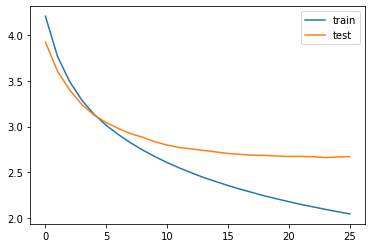

In [41]:
# 시각화 해보기
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
# decode sequence 메소드 정의

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

학습과 인코더, 디코서 세팅이 끝났다.

### 모델 테스트

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
# 테스트 데이터의 약50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ram brother man found hanging jaipur fort alongside slogans film padmavati claimed death linked threats film brother cannot commit suicide appears murder demand investigation death added ram 
실제 요약 : my brother death not linked to padmavati claims ram 
예측 요약 :  man of brother found dead in school


원문 : based analysis bills four private hospitals new delhi ncr national pharmaceutical pricing authority found hospitals sold medicines body added high profit possible purchases private hospitals cases keep 
실제 요약 : delhi sold drugs at profit body 
예측 요약 :  trees in delhi


원문 : uttar pradesh bjp charge lok sabha election wednesday asserted bjp win seats state added reason work done government leadership pm narendra modi said people towards pm bjp win 
실제 요약 : bjp will win lok sabha seats in uttar pradesh 
예측 요약 :  bjp will be in bjp in polls bjp


원문 : year old man year old son cleared examination open school odisha marks father arun kumar left studies class father passed away son kuma

### Result: 
#### 실제 요약은 원문의 text 기반으로 담긴 것이라 같은 내용으로 표현되어 있고,  
#### 예측 요약은 기존 요약과 다른 요약을 출력하면서 원문에서 유의미한 내용은 담고 있다.
#### 개선의 기회: seq2seq, 어텐션의 자체의 조합을 좀 더 좋게 수정할 수 있다.  
#### beam search, pre-trained word embedding, transformer와 같은 개선 방안들이 있다.

## 4. Summaize (추출적 요약)사용하기

summarize api  

* text(str):요약할 텍스트
* ratio(float, optional)- 요약문과 원본에서 선택되는 문장 비율. 0~1 사이의 값
* words(int or None, optional)- 출력에 포함할 단어 수(만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.)
* split(bool, optional)- True면 문장 list/False면 join된 문자열 반환


In [55]:
import requests
from summa.summarizer import summarize

# 다시 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data size: 98401


In [96]:
#원문 데이터 하나 
print('Original:')
print(summarize(data['text'][1], ratio=1))

Original:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [99]:
#원문 데이터를 0.5 ratio 출력

print('Summary:')
print(summarize(data['text'][1], ratio=0.5))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [95]:
# 리스트로 출력 값 받기 

print('Summary:')
print(summarize(data['text'][1], ratio=0.5, split=True))

Summary:
['Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.']


In [102]:
# 단어를 40개만 선택해보기

print('Summary:')
print(summarize(data['text'][1], words=40))

Summary:
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


## 5. 회고
추출적 요약은 원문에서 중요한 핵심 문장이나 단어를 추출하여 구성된 문장을 만드는 것이고,  
추상적 요약은 원문에 없던 문장이라도 핵심 문맥을 반영하여 새로운 문장을 생성해서 요약문을 만드는 것이다.  
대표적인 모델로 seq2seq가 있다. 이 방법은 기존적으로 지도 학습이기 때문에 원문뿐만 아니라 실제 요약문도 필요하다.  
그래서 데이터를 전처리하는 것도 비용이 큰 작업이다.  
데이터 전처리 과정에서 짧은 요약 데이터에 대해서는 문장의 길이가 길지 않아 불용어를 제거 하지 않았다.
병렬 처리를 했음에도 전처리 과정이 꽤나 길었다. ealry stopping은 유용했다.
희귀 단어는 요약에서 가중치가 적어 전처리 과정에서 많이 덜어냈다.
결과적으로 기존 요약과 다른 요약을 출력하면서 원문에서 유의미한 내용은 담고 있다.
추가적으로 seq2seq, 어텐션의 자체의 조합을 사용하면 좀 더 좋게 수정할 수 있다.
그리고 beam search, pre-trained word embedding, transformer와 같은 개선 방안들도 있는 것으로 확인했다.
   